# The problem 

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files

training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels
submissionFileFormat.csv: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what i need to predict. 

In [3]:
!pip install visualkeras

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import missingno as msno

from math import sin, cos, pi
import cv2, os
from tqdm.auto import tqdm

import keras
import tensorflow as tf
from keras import layers,regularizers, callbacks, utils, applications, optimizers
from keras.models import Sequential, Model, load_model

import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input, Flatten, Conv2D, LeakyReLU, GlobalAveragePooling2D, MaxPooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50

tf.random.set_seed(18)
np.random.seed(18)

In [9]:
!unzip ../input/facial-keypoints-detection/training.zip
!unzip ../input/facial-keypoints-detection/test.zip

train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./test.csv')
lookid_data = pd.read_csv('../input/facial-keypoints-detection/IdLookupTable.csv')

print(train_data.shape, test_data.shape)

Archive:  ../input/facial-keypoints-detection/training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  ../input/facial-keypoints-detection/test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
(7049, 31) (1783, 2)


In [11]:
train_data.head(2)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [13]:
test_data.head(5)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


Each cell in Column 'image' in train_data/test_data is a list composed of 96*96=9216 items which are seperated by space from each other. This is the X (fields) while y is the other 30 columns in train_data.

## looking at missing data 

In [14]:
train_data.isna().sum() 

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

<AxesSubplot:>

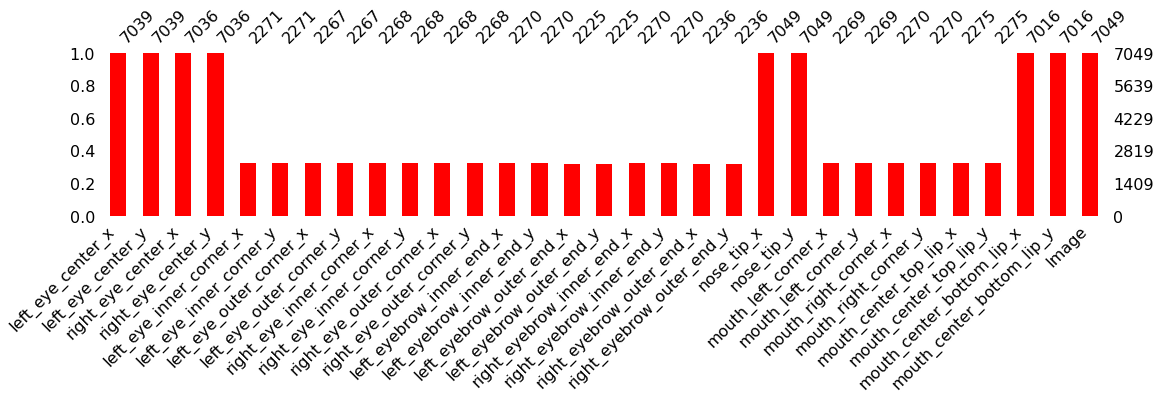

In [15]:
# Visualize the number of missing values as a bar chart
msno.bar(train_data,figsize=(18,3), color='red')

In [16]:
test_data.isna().sum()

ImageId    0
Image      0
dtype: int64

In [17]:
print("How many columns contain missing values?")
print(train_data.isnull().any().value_counts())
print("------------------")

How many columns contain missing values?
True     28
False     3
dtype: int64
------------------


**There is quite a lot features where a large amount of data is missing, we need to address this issue**

## Dealing with Missing Data 

We need to put some value to keep using them as we won't have enough data if u simply delete them

**We won't use the imputed data to our data augmentation : ⬇️**

In [18]:
print("Size of original dataframe: "+str(len(train_data))+'x'+str(len(train_data.columns))+'\n')
train_aug = train_data.dropna()
print("Size of dataframe after dropping rows of missing values, which is used for data augmentation: "
      +str(len(train_aug))+'x'+str(len(train_aug.columns))+'\n')

Size of original dataframe: 7049x31

Size of dataframe after dropping rows of missing values, which is used for data augmentation: 2140x31



### ffill() methods 

In [19]:
train_fill = train_data.fillna(method='ffill')
print("Size of dataframe after filling blanks: "
      +str(len(train_fill))+'x'+str(len(train_fill.columns))+'\n')

Size of dataframe after filling blanks: 7049x31



### KNN imputation

In [20]:
## TO DO AFTER
# from sklearn.impute import KNNImputer
# knn_imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')


# Preparation of the inputs and labels

In [26]:
def prepare_x_y(train):
    """
    Function which divide the training data into X (=image data) and y (=labels)
    
    INPUT 
        * train: dataframe with shape(n, 31)
    OUTPUT
        * X : numpy.array containing image data, shape=(n, 96, 96, 1)
        * y : numpy array containing labels, shape=(n, 30)
    """
    
    imgs = []
    points = []
    
    n = train.shape[0]
    
    X_tr = train['Image'] # X part
    y_tr = train.drop('Image',axis = 1) # y part
    
    for i in range(n):
        img = X_tr.iloc[i]
        img = img.split(' ')
        imgs.append(img)
        
        point = y_tr.iloc[i,:] # take the ith row data
        points.append(point)

    X_train = np.array(imgs,dtype = 'float')
    X_train = X_train.reshape(-1,96,96,1)
    y_train = np.array(points,dtype = 'float')
    X_train = X_train / 255.0
    
    return X_train, y_train

In [27]:
# data used as base for data augmentation
X_aug, y_aug = prepare_x_y(train_aug)

# check shapes
print(X_aug.shape)
print(X_aug.min(), X_aug.max())
print("")

print(y_aug.shape)
print(y_aug.min(), y_aug.max())

(2140, 96, 96, 1)
0.0 1.0

(2140, 30)
3.82624305628 95.8089831215


In [28]:
# data used directly in the training set
X_fill, y_fill = prepare_x_y(train_fill)

print(X_fill.shape)
print(X_fill.min(), X_fill.max())

print(y_fill.shape)
print(y_fill.min(), y_fill.max())

(7049, 96, 96, 1)
0.0 1.0
(7049, 30)
0.686592 95.9356444444


# Look at some images with keypoints on it 

In [31]:
def plot_images(images, points, ncols, shrinkage=0.2):
  """
  Function to plot images and their lables:
  INPUT:
      * images: numpy array with shape (N, d, d, c), dtype=float
      * points: numpy array with shape (N,), dtype=float
      * ncols: number of columns in the resulting image grid
      * shrinage: how much each image to be shrinked for display
  """
  
  nindex, height, width, intensity = images.shape
  nrows = nindex//ncols
  print(f"Number of rows: {nrows}, number of cols: {ncols}")
  
  fig_width = int(width*ncols*shrinkage)
  fig_height = int(height*nrows*shrinkage)

  fig, axes = plt.subplots(nrows, ncols, 
                          figsize=(fig_width, fig_height))
  print(f"Figure width: {fig_width}, height: {fig_height}")
  axes = axes.flatten()
  
  for k in range(nindex):
    img = images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    pnt_x = [points[k][2*j] for j in range(15)]
    pnt_y = [points[k][2*j+1] for j in range(15)]
    ax.scatter(pnt_x,pnt_y,s=200,c='r')
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


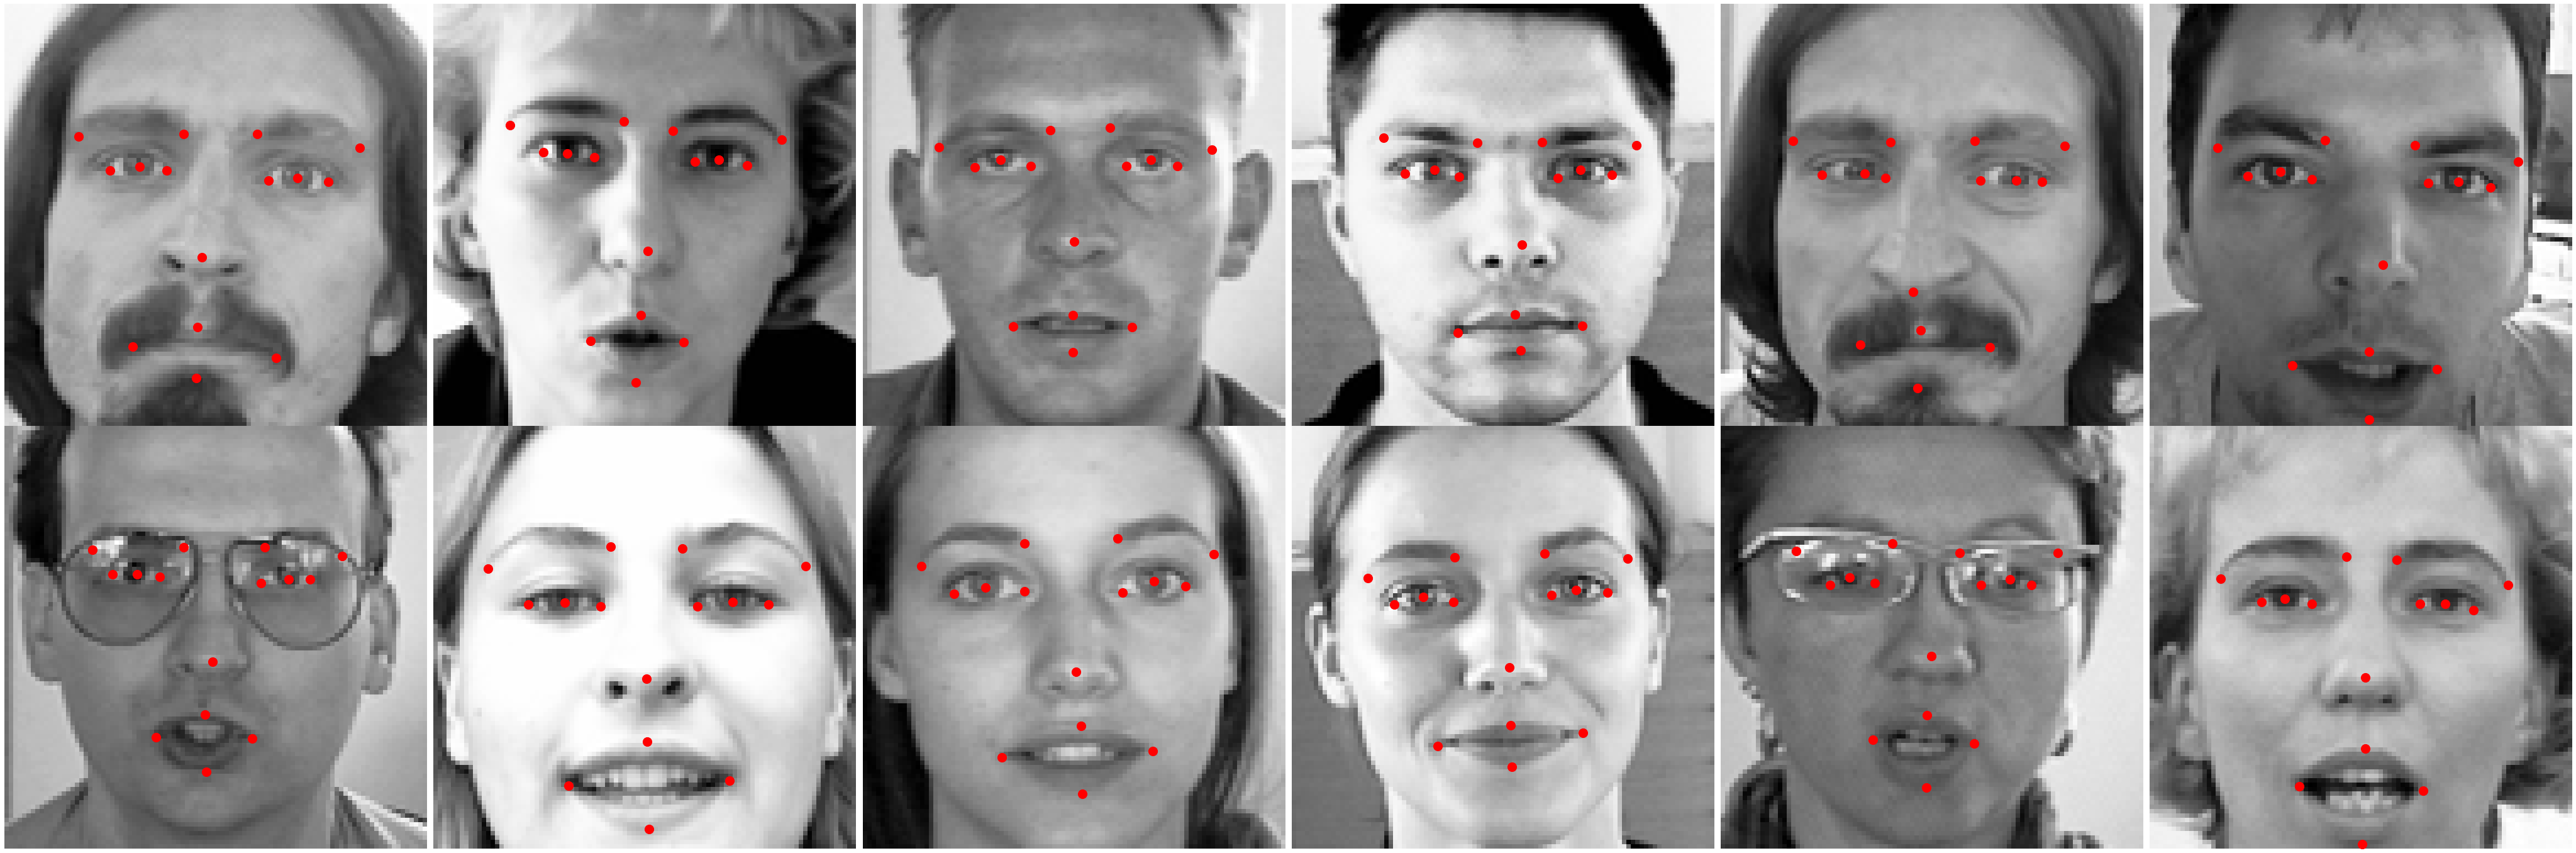

In [32]:
plot_images(X_aug[:12], y_aug[:12], 6, shrinkage=0.1)

In [33]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,  
                             zoom_range = 0.1,  
                             width_shift_range=0.1, 
                             height_shift_range=0.1)

In [34]:
(X, y) = datagen.flow(X_aug, y_aug)

ValueError: too many values to unpack (expected 2)